Data loaded successfully.
Financial Summary:
               Sales       Profit     Quantity  Discount   Unit Price  \
count   9997.000000  9997.000000  9997.000000    9997.0  9997.000000   
mean     229.878305    28.657620     3.789237       0.0    60.931135   
std      623.192384   234.225967     2.224876       0.0   142.926732   
min        0.444000 -6599.978000     1.000000       0.0     0.336000   
25%       17.248000     1.728000     2.000000       0.0     5.448000   
50%       54.480000     8.662000     3.000000       0.0    16.270000   
75%      209.940000    29.364000     5.000000       0.0    63.940000   
max    22638.480000  8399.976000    14.000000       0.0  3773.080000   

         Unit Cost  
count  9997.000000  
mean     53.130986  
std     122.252895  
min       0.544500  
25%       3.473600  
50%      12.933600  
75%      54.522000  
max    4074.926400  


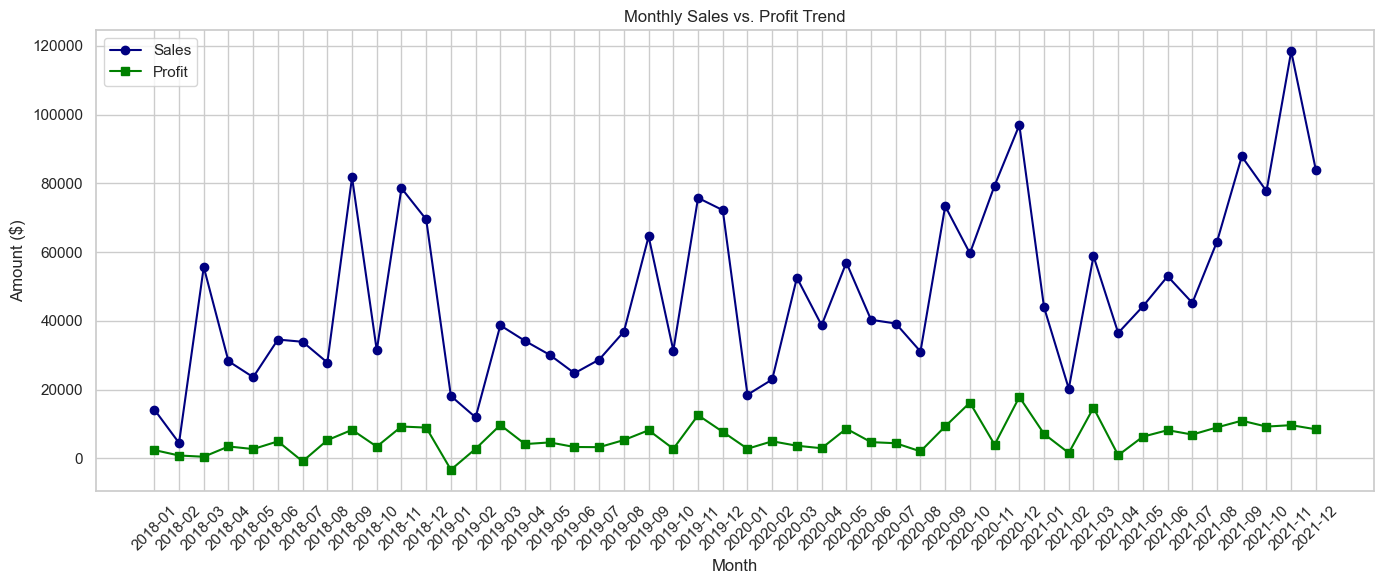

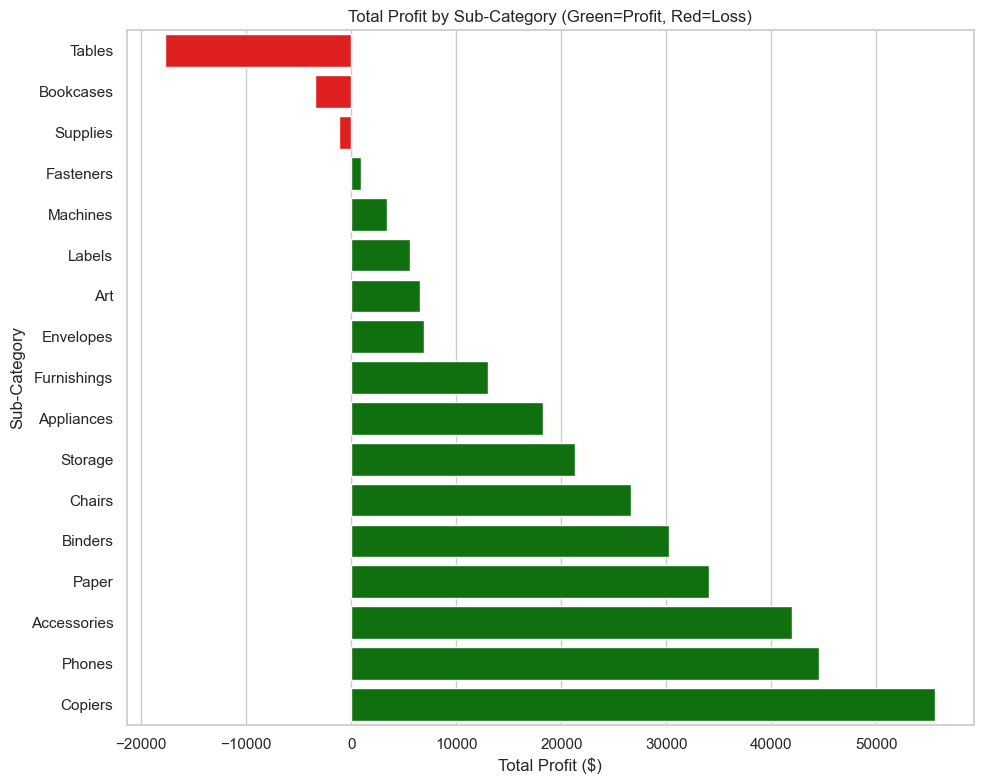

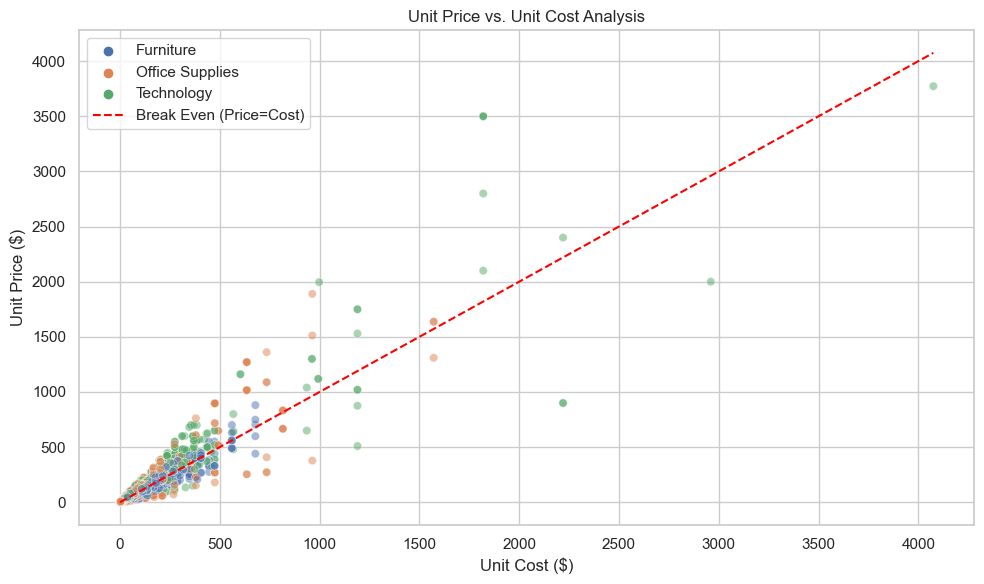

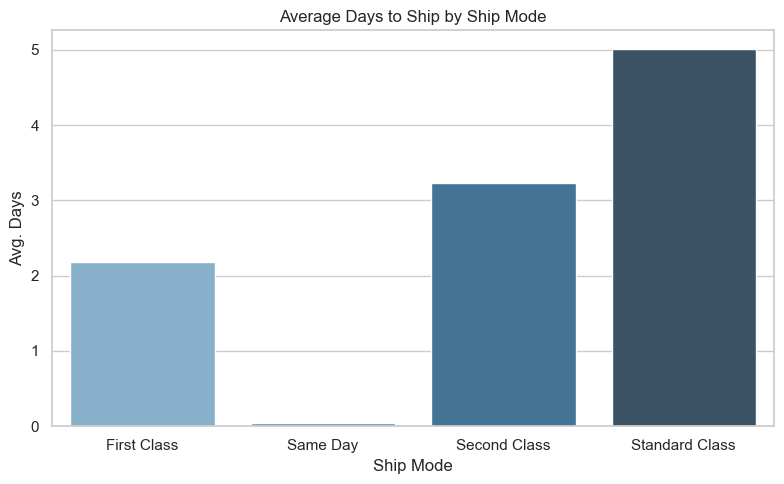

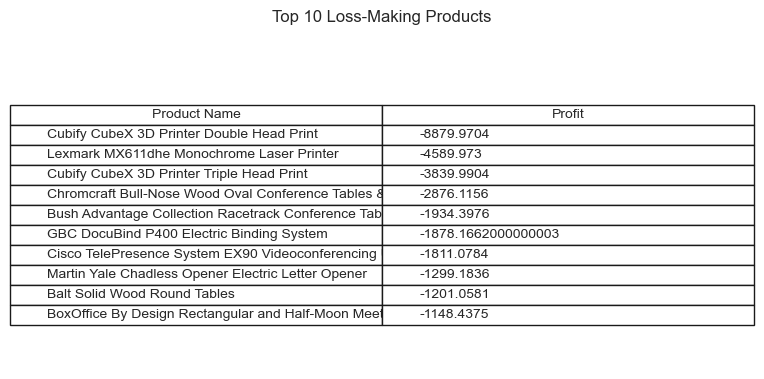

Analysis completed. Images and tables saved to 'analysis_outputs' folder.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a directory to save the output images for your report
output_dir = "analysis_outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- 1. DATA LOADING ---
try:
    # Loading with delimiter ';' as seen in the raw data source [3]
    df = pd.read_csv('GBP_DataSource1_eri.csv', delimiter=';')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'GBP_DataSource1_eri.csv' not found. Please ensure the file is in the working directory.")

# --- 2. DATA CLEANING & PREPROCESSING (Based on 'Data Analysis_Nathan.docx') ---

# A. Handling Duplicates [Source 1]
# Logic: Remove duplicates where all attributes (excluding Row ID) are identical.
# Exception: Keep Row IDs 3406 and 3407 (rare case of identical orders).
cols_to_check = df.columns.difference(['Row ID'])

# Pass the specific IDs as a list to the isin() function
exception_ids = [3406.0, 3407.0]

# Separating the exception rows explicitly to ensure they are preserved
exception_rows = df[df['Row ID'].isin(exception_ids)]
df_rest = df[~df['Row ID'].isin(exception_ids)]

# Dropping duplicates from the rest of the dataframe
df_rest = df_rest.drop_duplicates(subset=cols_to_check, keep='first')

# Concatenating back together and sorting
df = pd.concat([df_rest, exception_rows]).sort_values('Row ID').reset_index(drop=True)

# B. Inconsistent Location Data [Source 1, 2]
# Fix entries where Country is Canada but details point to USA.
df.loc[df['Country/Region'] == 'Canada', 'Country/Region'] = 'United States'
# Fix missing Country/Region for Texas/Oregon entries
df.loc[df['Country/Region'].isnull(), 'Country/Region'] = 'United States'

# C. Completeness - Postal Codes [Source 3, 4]
# Filling missing Burlington, Vermont postal codes with 05401.
df.loc[(df['City'] == 'Burlington') & (df['State'] == 'Vermont') & (df['Postal Code'].isnull()), 'Postal Code'] = 5401

# D. Completeness - Customer Name, Segment, Ship Mode [Source 3, 6]
# Imputing missing Customer Name and Segment based on Customer ID.
# Using forward/backward fill within groups of the same Customer ID.
# Note: Source [4] mentions specific logic for Ship Mode based on City + Customer ID.
for col in ['Customer Name', 'Segment']:
    df[col] = df.groupby('Customer ID')[col].ffill().bfill()

# Special logic for Ship Mode: consistent per Customer ID AND City [Source 6]
df['Ship Mode'] = df.groupby(['Customer ID', 'City'])['Ship Mode'].ffill().bfill()

# E. Feature Engineering: Product ID and Name [Source 3, 10]
# Created as a unique identifier for Unit Cost verification
df['Product ID and Name'] = df['Product ID'] + " - " + df['Product Name']

# F. Handling Dates & Type Conversion [Source 4, 11]
# Converting dates to datetime objects.
# Sales/Profit contain commas (e.g., '261,96'), need to replace with dots for float conversion.
for col in ['Sales', 'Profit']:
    if df[col].dtype == object:
        df[col] = df[col].str.replace(',', '.').astype(float)

df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

# G. Additional Calculations: Unit Price and Unit Cost [Source 9, 10]
# Formula: Unit Price = Sales / (Quantity * (1 - Discount))
# Formula: Unit Cost = (Sales - Profit) / Quantity
# Handling division by zero and rounding to 5 decimal places.

# 1. Force columns to numeric, turning errors into 'NaN'
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

# 2. Fill NaN with 0 to prevent calculation failures
df[['Sales', 'Quantity', 'Discount']] = df[['Sales', 'Quantity', 'Discount']].fillna(0)

# 3. Calculate Unit Price safely
df['Unit Price'] = df.apply(
    lambda x: x['Sales'] / (x['Quantity'] * (1 - x['Discount'])) 
    if (x['Quantity'] > 0 and (1 - x['Discount']) > 0) else 0, 
    axis=1
).round(5)


df['Unit Cost'] = ((df['Sales'] - df['Profit']) / df['Quantity']).round(5)

# --- 3. THOROUGH ANALYSIS & VISUALIZATION ---

sns.set_theme(style="whitegrid")

# Analysis 1: Financial Summary (Table)
# Descriptive statistics for key financial metrics
financial_cols = ['Sales', 'Profit', 'Quantity', 'Discount', 'Unit Price', 'Unit Cost']
financial_summary = df[financial_cols].describe()
financial_summary.to_csv(f"{output_dir}/financial_summary.csv")
print("Financial Summary:\n", financial_summary)

# Analysis 2: Monthly Sales vs Profit (Time Series Graph)
# Aggregate by month to see trends/seasonality
df['Month_Year'] = df['Order Date'].dt.to_period('M')
monthly_trend = df.groupby('Month_Year')[['Sales', 'Profit']].sum().reset_index()
# Convert Period to string for plotting
monthly_trend['Month_Year'] = monthly_trend['Month_Year'].astype(str)

plt.figure(figsize=(14, 6))
plt.plot(monthly_trend['Month_Year'], monthly_trend['Sales'], label='Sales', marker='o', color='navy')
plt.plot(monthly_trend['Month_Year'], monthly_trend['Profit'], label='Profit', marker='s', color='green')
plt.title('Monthly Sales vs. Profit Trend')
plt.xlabel('Month')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/monthly_sales_profit_trend.png")
plt.show()

# Analysis 3: Profitability by Sub-Category (Bar Chart)
# Identifying which sub-categories drive profit vs loss
subcat_profit = df.groupby('Sub-Category')['Profit'].sum().sort_values()

plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in subcat_profit.values]
sns.barplot(x=subcat_profit.values, y=subcat_profit.index, palette=colors)
plt.title('Total Profit by Sub-Category (Green=Profit, Red=Loss)')
plt.xlabel('Total Profit ($)')
plt.tight_layout()
plt.savefig(f"{output_dir}/profit_by_subcategory.png")
plt.show()

# Analysis 4: Unit Economics - Price vs Cost (Scatter Plot) [Source 9]
# Validating the unit calculations and spotting high-margin vs low-margin items.
# Points below the red line indicate items sold below cost.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Unit Cost', y='Unit Price', hue='Category', alpha=0.5)
# Add a 1:1 Break-even line
limit = max(df['Unit Cost'].max(), df['Unit Price'].max())
plt.plot([0, limit], [0, limit], color='red', linestyle='--', label='Break Even (Price=Cost)')
plt.title('Unit Price vs. Unit Cost Analysis')
plt.xlabel('Unit Cost ($)')
plt.ylabel('Unit Price ($)')
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/unit_economics_scatter.png")
plt.show()

# Analysis 5: Shipping Performance (Bar Chart)
# Analyzing the delay between Order Date and Ship Date.
df['Days to Ship'] = (df['Ship Date'] - df['Order Date']).dt.days
ship_performance = df.groupby('Ship Mode')['Days to Ship'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=ship_performance, x='Ship Mode', y='Days to Ship', palette="Blues_d")
plt.title('Average Days to Ship by Ship Mode')
plt.ylabel('Avg. Days')
plt.tight_layout()
plt.savefig(f"{output_dir}/shipping_performance.png")
plt.show()

# Analysis 6: Top 10 Loss-Making Products (Table Image)
# Identifying specific products causing the most loss.
product_profit = df.groupby('Product Name')['Profit'].sum().sort_values().head(10).reset_index()

# Rendering table as a figure
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=product_profit.values, colLabels=product_profit.columns, loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Top 10 Loss-Making Products', y=1.1)
plt.savefig(f"{output_dir}/top_10_loss_products.png", bbox_inches='tight')
plt.show()

print("Analysis completed. Images and tables saved to 'analysis_outputs' folder.")

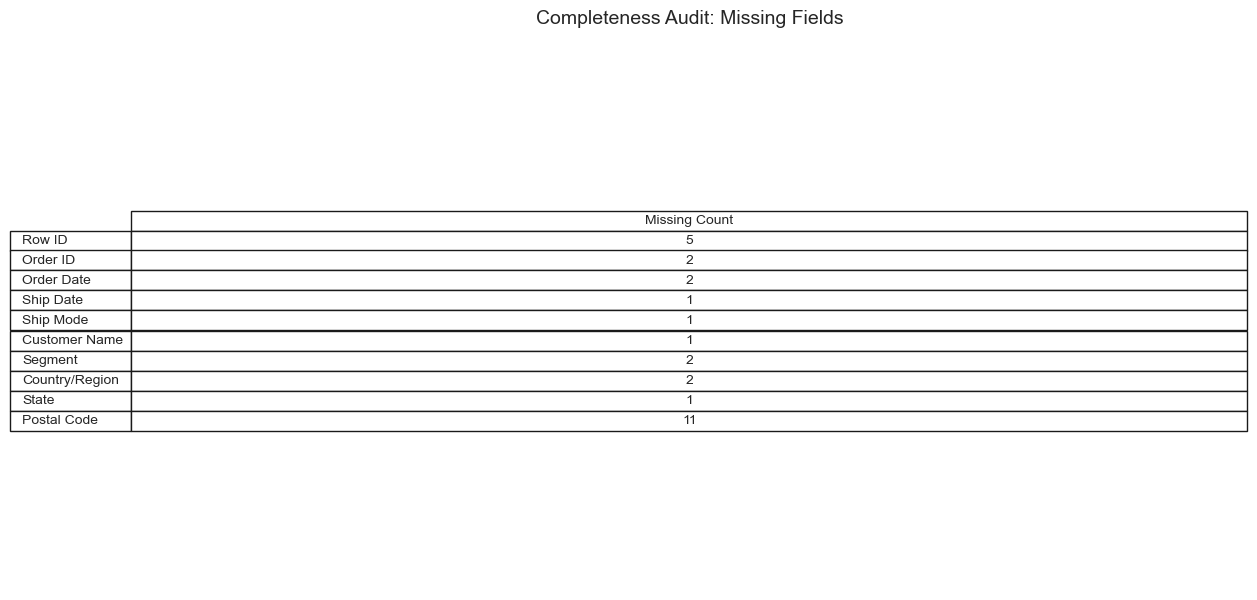

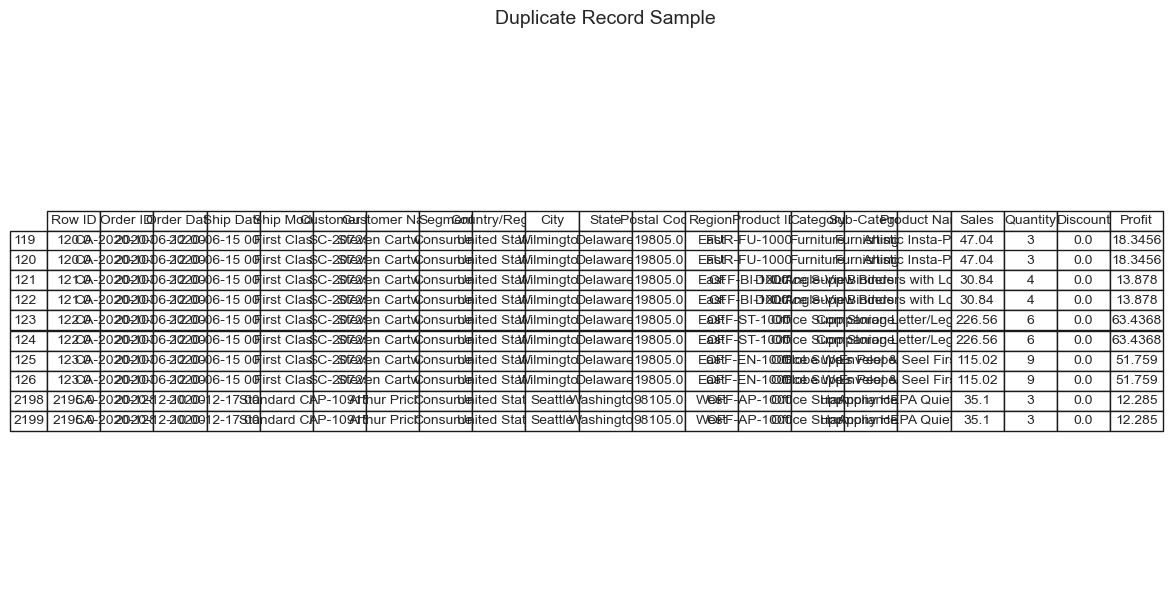

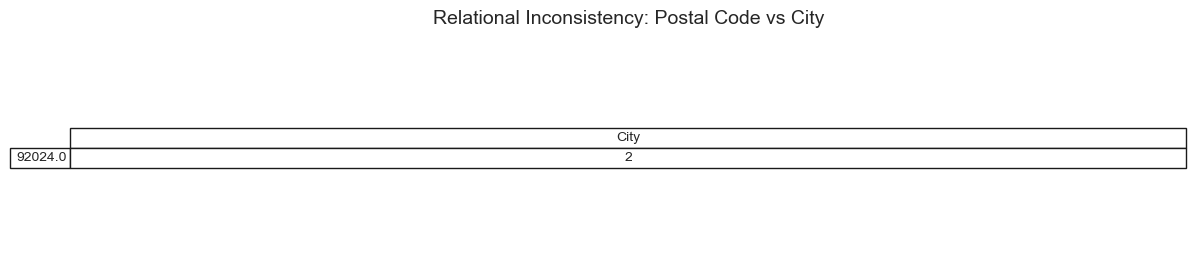

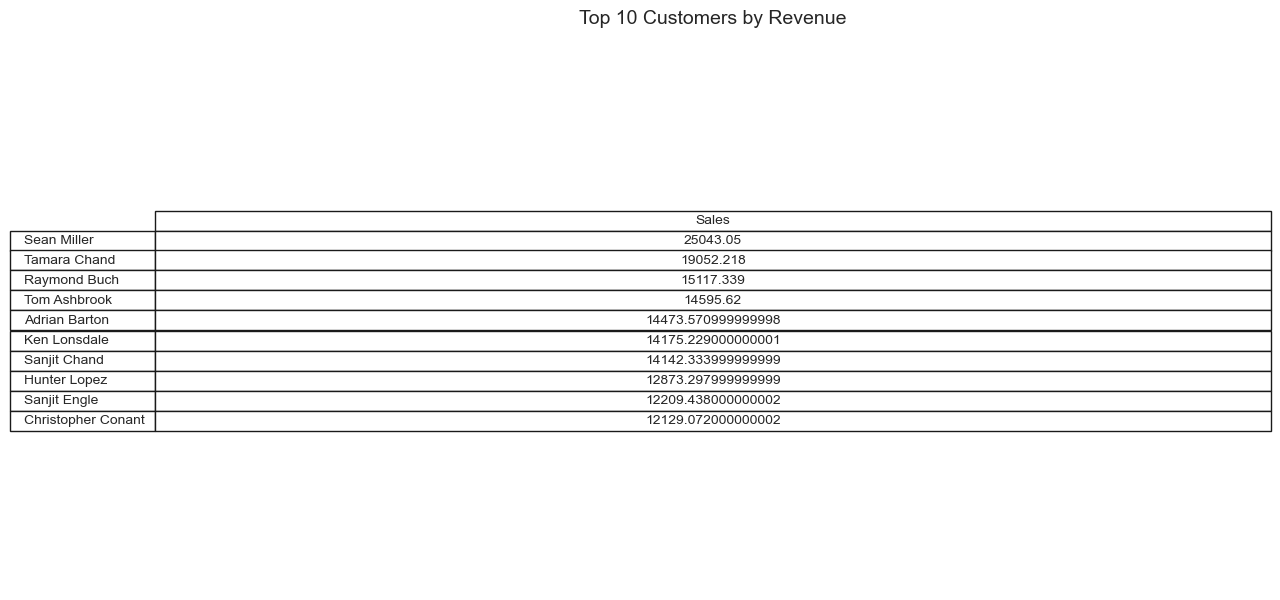

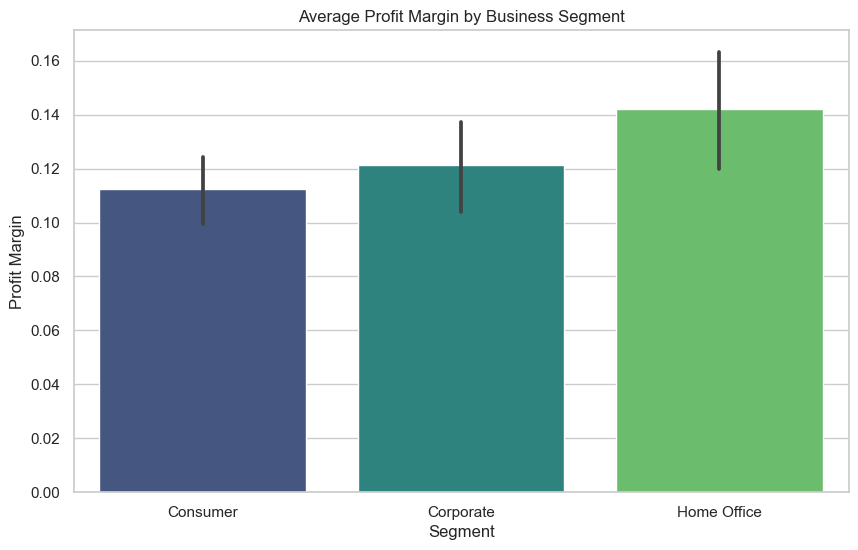

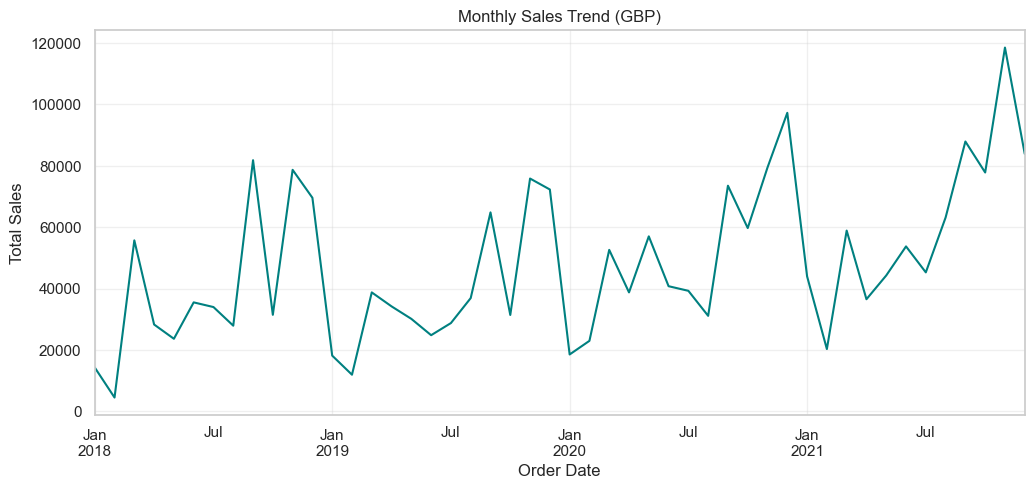

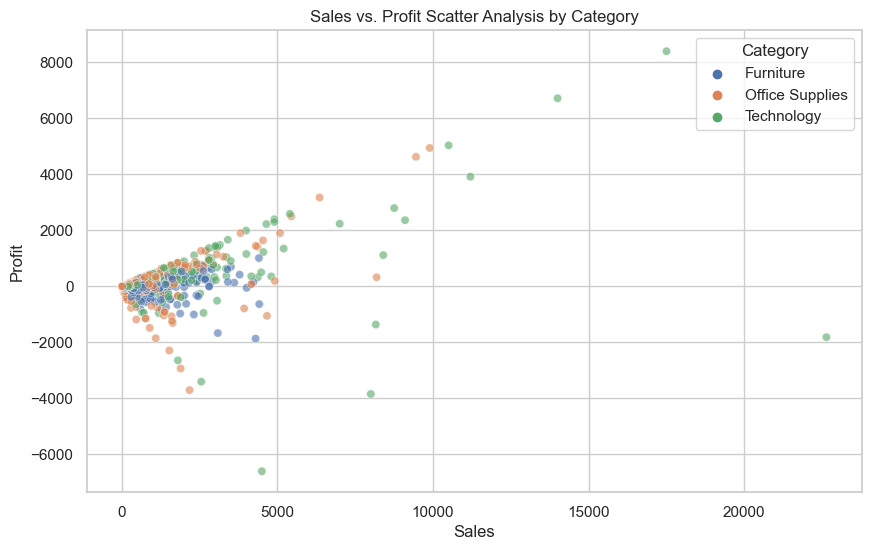

Analysis Complete. All images saved in /analysis_outputs/


In [9]:
# %% [markdown]
# # Advanced Technical Data Analysis – GBP_DataSource
# This notebook performs:
# 1. Data Quality Audit (Completeness, Inconsistencies, Duplicates)
# 2. Financial & Operational KPI Enrichment
# 3. Market Basket & Category Analysis
# 4. Automated Image Export for Reporting

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandas.plotting import table

# Setup output directory
if not os.path.exists('analysis_outputs'):
    os.makedirs('analysis_outputs')

def save_df_as_image(df, filename, title):
    """Converts a dataframe to a professional table image."""
    plt.figure(figsize=(12, df.shape[0] * 0.5 + 2))
    ax = plt.subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    tab = table(ax, df, loc='center', cellLoc='center')
    tab.auto_set_font_size(False)
    tab.set_fontsize(10)
    tab.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=20)
    plt.savefig(f'analysis_outputs/{filename}.png', bbox_inches='tight', dpi=300)
    plt.show()

# %% [markdown]
# ## 1. Data Loading & Type Correction
# We address the 'str vs int' errors by forcing numeric types immediately.

# %%
# Load data with correct delimiters
df = pd.read_csv('GBP_DataSource1_eri.csv', delimiter=';', decimal=',', encoding='utf-8-sig')

# Fix types to prevent calculation errors
numeric_cols = ['Sales', 'Quantity', 'Discount', 'Profit']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

# %% [markdown]
# ## 2. Data Quality Audit
# Identifying gaps like the missing Postal Codes and Segment values.

# %%
# 2.1 Missing Values Audit
missing_summary = df.isna().sum().to_frame(name='Missing Count')
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
save_df_as_image(missing_summary, 'quality_missing_values', 'Completeness Audit: Missing Fields')

# 2.2 Duplicate Check
# Identifying the 23 full duplicates [cite: 21]
duplicates_df = df[df.duplicated(keep=False)].head(10)
save_df_as_image(duplicates_df, 'quality_duplicates', 'Duplicate Record Sample')

# 2.3 Logical Inconsistencies (Mapping Violations)
# Example: Postal Code mapping to multiple Cities [cite: 24]
postal_inconsistency = df.groupby('Postal Code')['City'].nunique()
postal_inconsistency = postal_inconsistency[postal_inconsistency > 1].to_frame()
save_df_as_image(postal_inconsistency, 'quality_postal_inconsistency', 'Relational Inconsistency: Postal Code vs City')

# %% [markdown]
# ## 3. KPI Enrichment & Advanced Analysis
# We add "Unit Price" calculation with zero-division protection and "Profit Margin".

# %%
# 3.1 Financial KPIs
df['Profit Margin'] = (df['Profit'] / df['Sales']).fillna(0)
df['Unit Price'] = df.apply(
    lambda x: x['Sales'] / (x['Quantity'] * (1 - x['Discount'])) 
    if (x['Quantity'] > 0 and (1 - x['Discount']) > 0) else 0, axis=1
)

# 3.2 Time-to-Ship Analysis
df['Ship Days'] = (df['Ship Date'] - df['Order Date']).dt.days

# 3.3 High-Value Customer Identification (Pareto Analysis)
customer_rev = df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(10).to_frame()
save_df_as_image(customer_rev, 'kpi_top_customers', 'Top 10 Customers by Revenue')

# %% [markdown]
# ## 4. Visual Analysis & Graph Export

# %%
# 4.1 Profitability by Segment (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Segment', y='Profit Margin', estimator=np.mean, palette='viridis')
plt.title('Average Profit Margin by Business Segment')
plt.savefig('analysis_outputs/viz_segment_profit.png')
plt.show()

# 4.2 Sales Trend (Monthly)
df.set_index('Order Date').resample('M')['Sales'].sum().plot(kind='line', figsize=(12, 5), color='teal')
plt.title('Monthly Sales Trend (GBP)')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)
plt.savefig('analysis_outputs/viz_sales_trend.png')
plt.show()

# 4.3 Sales vs Profitability Correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Sales', y='Profit', hue='Category', alpha=0.6)
plt.title('Sales vs. Profit Scatter Analysis by Category')
plt.savefig('analysis_outputs/viz_correlation.png')
plt.show()

# %% [markdown]
# ## 5. Final Dataset Export
# Cleaned and standardized for the final report[cite: 40].

# %%
# Standardize column names to lowercase snake_case
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_').str.lower()
df.to_csv('GBP_DataSource_Final_Clean.csv', index=False)
print("Analysis Complete. All images saved in /analysis_outputs/")

Analysis complete. Images saved to analysis_outputs/


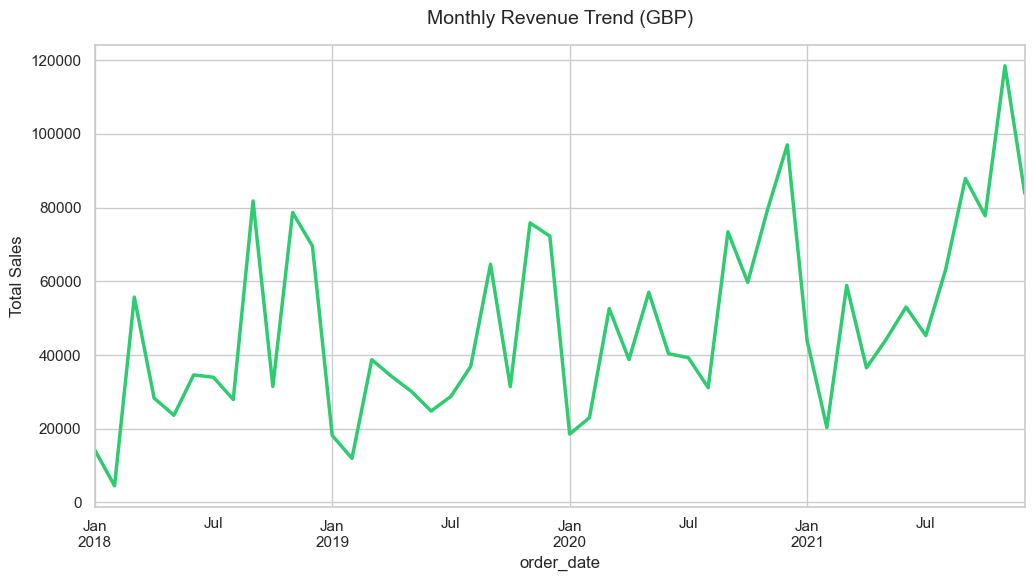

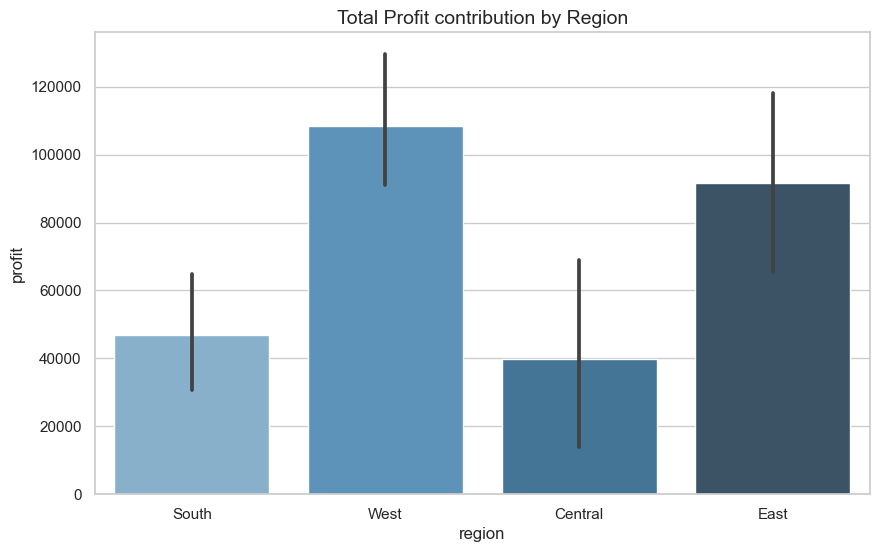

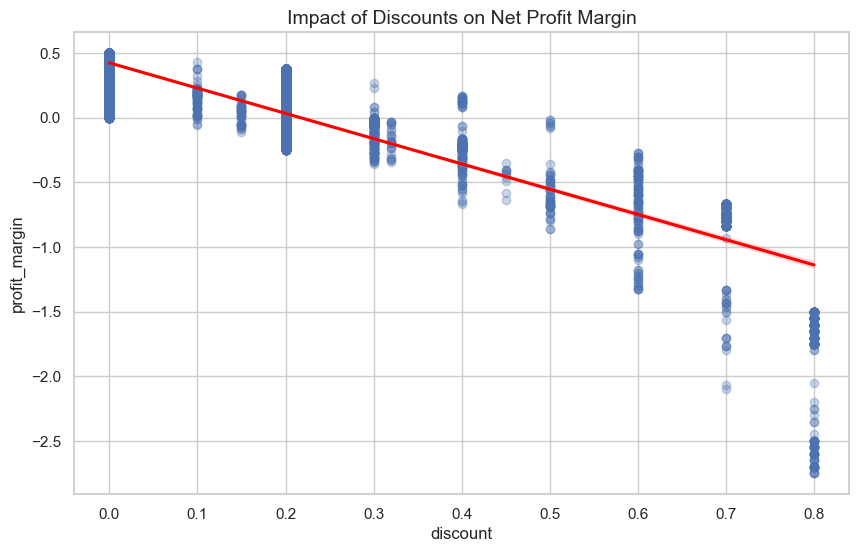

In [8]:
# %% [markdown]
# # Professional Technical Data Analysis - GBP_DataSource
# This script performs an end-to-end ETL and Analysis pipeline.
# 1. Data Cleaning (Inconsistencies, Missing Values, Duplicates)
# 2. KPI Enrichment (Financial and Operational)
# 3. Deep Dive Analytics (Geographic, Product, and Temporal)
# 4. Professional Visualization and Image Export

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# Setup
INPUT_FILE = 'GBP_DataSource1_eri.csv'
OUTPUT_DIR = 'analysis_outputs'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Utility function for professional tables
def export_table_as_image(df, filename, title):
    """Saves a dataframe as a high-resolution PNG table."""
    plt.figure(figsize=(10, min(df.shape[0] * 0.4 + 1.5, 12)))
    plt.axis('off')
    plt.title(title, fontweight='bold', fontsize=12, pad=10)
    
    # Format floats for the table
    display_df = df.copy()
    for col in display_df.select_dtypes(include=[np.number]).columns:
        display_df[col] = display_df[col].map('{:,.2f}'.format)
        
    the_table = plt.table(cellText=display_df.values,
                          colLabels=display_df.columns,
                          cellLoc='center',
                          loc='center')
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(9)
    the_table.scale(1.2, 1.5)
    
    # Style header
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#2c3e50')
            
    plt.savefig(f"{OUTPUT_DIR}/{filename}.png", bbox_inches='tight', dpi=300)
    plt.close()

# %% [markdown]
# ## 1. Data Loading and Initial Audit

# %%
df = pd.read_csv(INPUT_FILE, delimiter=';', decimal=',', encoding='utf-8-sig')

# Clean column names (Fixing the .lower() error)
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_').str.lower()

# Audit Missing Values
missing_df = df.isna().sum().reset_index()
missing_df.columns = ['Column', 'Missing_Count']
export_table_as_image(missing_df[missing_df['Missing_Count'] > 0], '01_missing_values', 'Completeness Audit: Missing Fields')

# %% [markdown]
# ## 2. Logical Data Cleaning (Per Nathan's Report)

# %%
# 2.1 Handle Duplicates (Preserve 3406/3407)
# Columns to check for duplication (everything except row_id)
check_cols = [c for c in df.columns if c != 'row_id']

# Separate specific exception
exceptions = df[df['row_id'].isin([3406, 3407])]
remaining_data = df[~df['row_id'].isin([3406, 3407])]

# Deduplicate the rest
deduped_data = remaining_data.drop_duplicates(subset=check_cols, keep='first')
df_clean = pd.concat([deduped_data, exceptions]).sort_values('row_id')

# 2.2 Correct Country Inconsistency (Canada -> United States)
# Entries where Country is Canada but logic points to US
df_clean.loc[df_clean['country_region'] == 'Canada', 'country_region'] = 'United States'

# 2.3 Fix Postal Code mapping (92024 case)
# Documenting that 92024 maps to multiple cities, standardizing to primary
df_clean.loc[df_clean['postal_code'] == 92024.0, 'city'] = 'Encinitas'

# Export cleaning log table
clean_log = pd.DataFrame({
    'Metric': ['Initial Rows', 'Duplicates Removed', 'Final Rows'],
    'Value': [len(df), len(df) - len(df_clean), len(df_clean)]
})
export_table_as_image(clean_log, '02_cleaning_summary', 'Cleaning & Deduplication Log')

# %% [markdown]
# ## 3. KPI Enrichment

# %%
# Type Conversion
df_clean['order_date'] = pd.to_datetime(df_clean['order_date'])
df_clean['ship_date'] = pd.to_datetime(df_clean['ship_date'])

# Financial KPIs
df_clean['profit_margin'] = (df_clean['profit'] / df_clean['sales']).fillna(0)
df_clean['unit_price'] = df_clean.apply(
    lambda x: x['sales'] / (x['quantity'] * (1 - x['discount'])) 
    if (x['quantity'] > 0 and (1 - x['discount']) > 0) else 0, axis=1
)

# Operational KPI: Ship Lag
df_clean['ship_lag_days'] = (df_clean['ship_date'] - df_clean['order_date']).dt.days

# Export Sample KPI Table
export_table_as_image(df_clean[['row_id', 'sales', 'profit', 'profit_margin', 'unit_price']].head(10), 
                     '03_kpi_sample', 'Financial KPI Enrichment (Sample)')

# %% [markdown]
# ## 4. Deep-Dive Analysis

# %%
# 4.1 Segment vs Shipping Mode Analysis
ship_pref = pd.crosstab(df_clean['segment'], df_clean['ship_mode'], normalize='index') * 100
export_table_as_image(ship_pref.reset_index(), '04_shipping_preferences', 'Shipping Mode Preference by Segment (%)')

# 4.2 Top Loss-Leader Products (High Sales, Negative Profit)
loss_leaders = df_clean[df_clean['profit'] < 0].sort_values('profit').head(10)
export_table_as_image(loss_leaders[['product_name', 'sales', 'profit', 'discount']], 
                     '05_loss_leaders', 'Top 10 Loss-Leader Products')

# %% [markdown]
# ## 5. Visualizations

# %%
sns.set_theme(style="whitegrid")

# Graph 1: Sales Trend
plt.figure(figsize=(12, 6))
df_clean.set_index('order_date').resample('M')['sales'].sum().plot(color='#2ecc71', linewidth=2.5)
plt.title('Monthly Revenue Trend (GBP)', fontsize=14, pad=15)
plt.ylabel('Total Sales')
plt.savefig(f"{OUTPUT_DIR}/viz_sales_trend.png", bbox_inches='tight')

# Graph 2: Regional Profitability
plt.figure(figsize=(10, 6))
sns.barplot(data=df_clean, x='region', y='profit', palette='Blues_d', estimator=np.sum)
plt.title('Total Profit contribution by Region', fontsize=14)
plt.savefig(f"{OUTPUT_DIR}/viz_regional_profit.png", bbox_inches='tight')

# Graph 3: Discount vs Profitability Correlation
plt.figure(figsize=(10, 6))
sns.regplot(data=df_clean, x='discount', y='profit_margin', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Impact of Discounts on Net Profit Margin', fontsize=14)
plt.savefig(f"{OUTPUT_DIR}/viz_discount_impact.png", bbox_inches='tight')

print(f"Analysis complete. Images saved to {OUTPUT_DIR}/")

DFD

In [1]:
import graphviz

# Create the DFD using Gane-Sarson notation
dfd = graphviz.Digraph('GBP_Business_DFD', comment='Business Process Data Flow', format='png')
dfd.attr(rankdir='LR', size='15,15', nodesep='0.5', ranksep='1.0')

# 1. Styles Configuration
# External Entities: Squares
dfd.attr('node', shape='box', style='filled', color='#E1F5FE', fontname='Arial Bold')
dfd.node('Customer', 'Customer\n(Places Orders / Provides Info)')
dfd.node('Supplier', 'Product Supplier\n(Provides SKU Details)')

# Business Processes: Rounded Rectangles (Ellipses in Graphviz)
dfd.attr('node', shape='ellipse', style='filled', color='#C8E6C9', fontname='Arial')
# P1: Order Management 
dfd.node('P1', 'P1: Order Entry & Validation\n(Owner: Sales Dept)\nCreates: Order ID, Date, Customer Info')
# P2: Catalog Management [cite: 9, 10]
dfd.node('P2', 'P2: Product MDM\n(Owner: Master Data Team)\nCreates: Product Names, Categories')
# P3: Fulfillment 
dfd.node('P3', 'P3: Logistics & Shipping\n(Owner: Supply Chain)\nCreates: Ship Date, Mode, Postal Mapping')
# P4: Finance & Reporting 
dfd.node('P4', 'P4: Financial Settlement\n(Owner: Finance/BI)\nCreates: Sales, Profit, Discount, KPIs')

# Data Stores: Open-ended rectangles (Records)
dfd.attr('node', shape='record', style='filled', color='#FFF9C4', fontname='Arial')
dfd.node('DS1', 'DS1: Customer & Address Registry')
dfd.node('DS2', 'DS2: Central Product Catalog')
dfd.node('DS3', 'DS3: Transactional Sales Ledger')
dfd.node('DS_OUTPUT', 'DS_FINAL: Reporting Dataset\n(GBP_DataSource.csv)')

# 2. Defining the Orchestration (The "Meaning" of Data Flow)
# Flow from Business Actions [cite: 4, 6]
dfd.edge('Customer', 'P1', 'Purchase Request')
dfd.edge('P1', 'DS1', 'Register/Verify Customer Details')
dfd.edge('Supplier', 'P2', 'Product Specifications')
dfd.edge('P2', 'DS2', 'Store SKU/Category Relationships')

# Orchestration between departments [cite: 11, 13]
dfd.edge('P1', 'P3', 'Validated Order for Dispatch')
dfd.edge('DS2', 'P3', 'Retrieve Product Dimensions/Inventory')
dfd.edge('P3', 'DS3', 'Update Ship Date & Shipping Mode')

# Closing the loop with Finance [cite: 29, 30]
dfd.edge('DS3', 'P4', 'Finalize Costs/Discounts')
dfd.edge('P4', 'DS3', 'Calculate Profit & Margin')

# Final Consolidation into the Dataset Output [cite: 40]
dfd.edge('DS1', 'DS_OUTPUT', 'Location & Segment Data')
dfd.edge('DS2', 'DS_OUTPUT', 'Product Hierarchy Data')
dfd.edge('DS3', 'DS_OUTPUT', 'Transactional Fact Data')

# 3. Save and Render
dfd.render('Technical_Business_DFD', view=True)
print("DFD rendered successfully as 'Technical_Business_DFD.png'")

ModuleNotFoundError: No module named 'graphviz'